In [1]:
using Interact, Plots, DifferentialEquations, LinearAlgebra
using NonLinearDynamicsCourse

WebIO._IJuliaInit()

┌ Info: Precompiling NonLinearDynamicsCourse [6762868a-e78a-451a-a6ea-484381d56062]
└ @ Base loading.jl:1342


# Flujo 2D Espacio de fases y campo vector

Los flujos en una dimensión, si bien pueden bifurcar, tienen un repertorio muy limitado de comportamientos (básicamente diverger a infinito o converger a un punto fijo). 

Los flujos en 2D incorporan un nuevo comportamiento y un nuevo conjunto límite (o equilibrio) además de los puntos fijos. El comportamiento nuevo es la **oscilación** y el nuevo equilibrio asociado con la oscilación se llama **ciclo límite**. Esto, como es de imaginarse, amplía muchísimo el repertorio de comportamientos posibles y agrega un nuevo tipo de bifurcación que no está presente en flujos 1D (bifrucación de Hopf). 

Otro elemento nuevo que va a aparecer en los flujos 2D es que además de puntos fijos atractores y repulsores existen puntos fijos que son atractores en una dirección y repulsores en otra, motivo por el cual se llaman puntos silla (o saddle) en alusión a la forma de la silla de montar que atrae en la direccion frente-atrás pero repele hacia los costados. Esas direcciones en las que se aproximan o alejan de los puntos silla van a funcionar como organizadoras del flujo global. La organización del flujo global es un último elemento que se agrega en dos dimensiones, porque pueden ocurrir cambios topológicos en esa organización del flujo sin que haya cambios locales. Todas las bifurcaciones que vimos hasta ahora ocurren por cambios en la cantidad y estabilidad de puntos fijos se conoces como bifurcaciones locales. Las bifurcaciones asociada a esos cambios en la organización del flujo que no son no reducibles a cambios en los puntos fijos se conocen como  **bifurcaciones globales**, y son bastante más difíciles de estudiar. 

Finalmente, muchas de las propiedades, estrategias de análisis y herramientas numéricas que vamos a ver para flujos 2D nos van a servir para sistemas de mayor dimensión. El único comportamiento que no es posible en flujos 2D y que va a aparecer recién cuando incorporemos una dimensión adicional es el aperiódico con sensibilidad a las condiciones iniciales, también llamado caótico. 

## Forma general del flujo

Un flujo 2D en el plano $(x,y)$ de forma general esta dado por las ecuaciones diferenciales:

$\dot{x} = f(x,y)$

$\dot{y} = g(x,y)$

donde $f$ y $g$ son dos funciones de dos variables que tambien pueden verse como una **funcion vectorial** o un **campo vector**. Este último nombre proviene del hecho de que a cada punto del espacio de fases $(x,y)$ (el **campo**) le corresponde un par de valores que forman un **vector** tangente a la trayectoria en ese punto, es decir que apuntan en la direccion del flujo. 

El nombre "flujo" toma un sentido mas literal en dos dimensiones, porque las trayectorias pueden verse como las lineas de flujo de un fluído moviéndose en dos dimensiones y el campo vector como el campo de velocidades de ese fluído. Por supuesto que esta es una imagen mental porque los fluídos reales obedecen a sus propias ecuaciones mientras que $f$ y $g$ son funciones arbitrarias. Pero siguiendo con la analogía líquida, los puntos fijos atractores podrían interpretarse como sumideros (sinks) de flujo y los repulsores como fuentes (sources). Y vamos a ver que las direcciones atractoras de los puntos silla funcionan como "divisorias de aguas" que separan diferentes "cuencas de atracción" que llevan a diferentes conjuntos límites o sea diferentes destinos.

Para ilustrar esto vamos a ver algunos ejemplos de sistemas dinámicos en 2D sin hacer ningún tipo de análisis, sólo para ver algunas formas de representar el flujo en el espacio de fases. 

## Ejemplos de flujo

Comenzamos con el oscilador armónico amortiguado, que es un sistema lineal:

$\dot{x} = y$

$\dot{y} = -Kx -\gamma y$

La primera ecuacion solo especifica que la variacion temporal de la posicion corresponde a la velocidad. 

La segunda ecuacion, que proviene de la segunda Ley de Newton combinada con la Ley de Hooke especifica que la variacion de la velocidad (aceleracion) es propocional a la posicion con una constante $K>0$ y signo negativo y que la fricción conduce por si sola a un decaimiento exponencial de la velocidad (recordar el efecto de un término lineal con signo negativo en los sistemas lineales 1D) con una constante positiva $\gamma$



In [2]:
function oscharmdamp!(du,u,p,t)
    (K,γ) = p
    du[1] = u[2]
    du[2] = -K*u[1]-γ*u[2]
end    

oscharmdamp! (generic function with 1 method)

Un par de comentarios sobre la forma de esta función. Por un lado ya no puede ser definida en una linea por eso queda definida como las funciones en Julia. Las funciones pueden modificar sus argumentos y en ese caso su nombre termina con un "bang" $!$. Y lo último es que en la primera linea de la función hacemos un "unpacking" del vector de parámetros $p$ para mayor claridad. En este caso no es muy necesario pero mas adelante cuando tengamos muchos parámetros no va a ser facil recordar a qué correspondia $p[5]$.

Vamos a elegir primero la representación más simple del flujo, que es la de una trayectoria para un determinada condición inicial, y lo hacemos integrando directamente el sistema con solve:

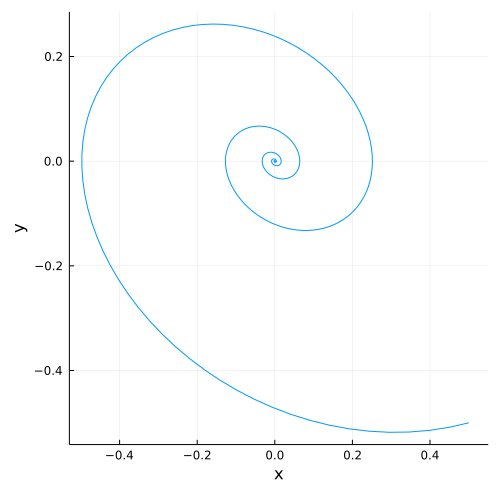

In [3]:
u0 = [0.5;-0.5]
K = 0.5; γ=0.3
tspan = (0,100.0)
prob = ODEProblem(oscharmdamp!, u0, tspan, [K,γ])
sol = solve(prob)
plot(sol,vars=(1,2),legend=false,xlabel="x",ylabel="y",size=(500,500))

Que como era de esperarse partiendo de $(0.5,-0.5)$ converge en forma de espiral al único punto fijo en el origen (atractor o sumidero).

Lo siguiente es representar un conjunto de trayectorias, que también podemos hacer de forma directa usando EnsambleProblem y definiendo (por única vez) una función (prob_func) que resetea la condición inicial (remake) a  la  i-ésima condicion inicial de un array de condiciones iniciales ($u0_{arr}$). $i$ es un contador interno del ensemble.

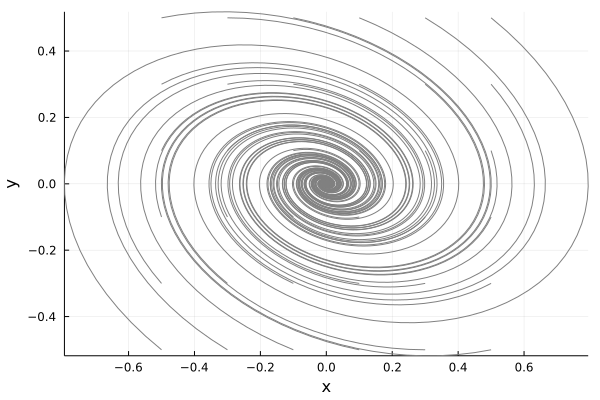

In [4]:
u0_arr = vec([[0.2*i-0.5,0.2*j-0.5] for i=0:5, j=0:5]) 

function prob_func(prob,i,repeat)
  remake(prob,u0=u0_arr[i])
end

ensemble_prob = EnsembleProblem(prob,prob_func=prob_func)
sol = solve(ensemble_prob,EnsembleThreads(),trajectories=length(u0_arr))
plot(sol,vars=(1,2),color=:gray,xlabel="x",ylabel="y")

Para representaciones más acabadas vamos a usar algunas funciones de la librería del curso. Por ejemplo, para ilustrar la idea del "campo vector" vamos a usar la funcion **flux2d_vectorfield** que recibe primero dos argumentos obligatorios en orden:
- la funcion del sistema dinamico definida in-place
- el vector de parámetros

Luego tiene como parametros opcionales (siempre invocados con nombre):
- xlims: los limites en el rango x (default [-1,1])
- ylims: los limites en el rango y (default [-1,1]) conviene que sea similar a xlims por una cuestion de escala
- npts: la cantidad de puntos en un lado de la grilla (hace una grilla cuadrada). Por defecto es 21 asi que hace 441 vectores.

En el grafico incorporamos ademas una solucion en linea roja (notar que tenemos que volver a integrar porque habiamos sobreescrito sol)

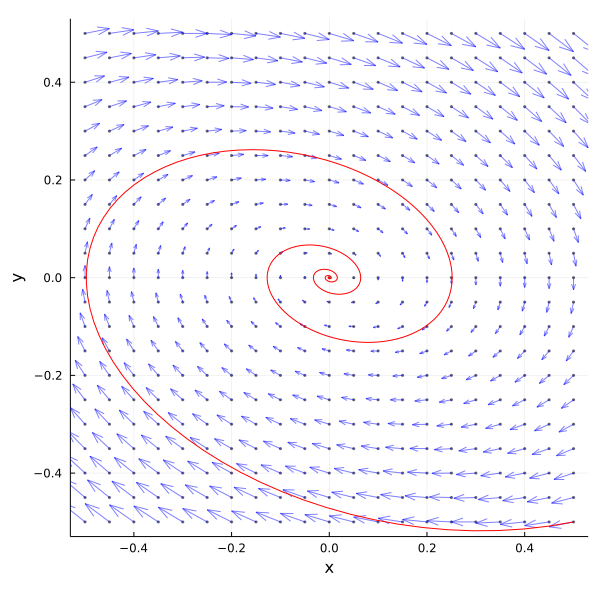

In [5]:
xlims=[-0.5,0.5]
ylims=[-0.5,0.5]
p1 = flux2d_vectorfield(oscharmdamp!,[K,γ];xlims=xlims,ylims=ylims)
sol = solve(prob)
plot!(p1,sol,vars=(1,2),color=:red,xlims=xlims,ylims=ylims)

Se puede apreciar que para puntos cercanos a la curva el vector del campo es tangente a la curva. Podemos pensar a la trayectoria roja (la solución de las ecuaciones diferenciales para la condicion inicial $(0.5,-0.5)$) como una particula flotando en la superficie del fluido guiada por los vectores azules. Notar que además los vectores nos dan una información adicional que no está en la trayectoria: la velocidad a la que evoluciona el estado del sistema sobre la trayectoria. Por ejemplo cuando $x$ e $y$ tienen el mismo signo (arriba a la derecha y abajo a la izquierda) las trayectorias evolucionan más rápido (los vectores son mas largos) que en el caso contrario. Por que?

Vamos a ver otro campo vector pero ahora de un sistema no lineal, para ilustrar algún comportamiento del flujo diferente de la convergencia a un punto fijo. Elegimos el oscilador no lineal de **Van der Pol** que vamos a ver con más detalle más adelante:

\begin{aligned}
\dot{x} & = y \\
\dot{y} & =  -Kx-\gamma y(x^2-1)  
\end{aligned}


In [6]:
function vdp!(du,u,p,t)
    (K,γ) = p
    du[1] = u[2]
    du[2] = -K*u[1]-γ*u[2]*(u[1]*u[1]-1.0)
    return # no devuelve nada
end    

vdp! (generic function with 1 method)

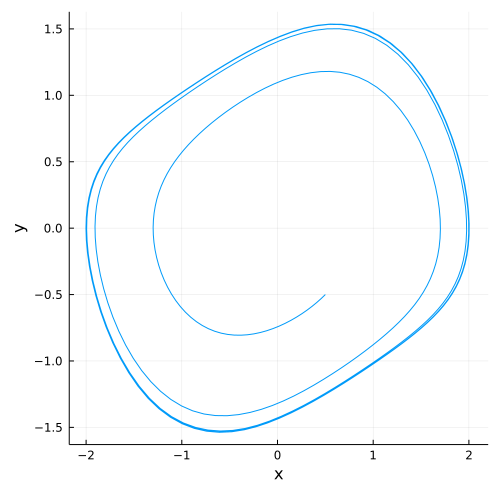

In [7]:
u0 = [0.5;-0.5]
K = 0.5; γ=0.3
tspan = (0,100.0)
prob = ODEProblem(vdp!, u0, tspan, [K,γ])
sol = solve(prob)
plot(sol,vars=(1,2),legend=false,xlabel="x",ylabel="y",size=(500,500))

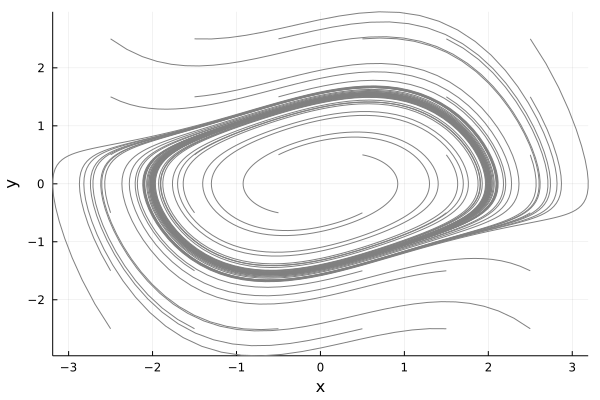

In [8]:
u0_arr = vec([[i-2.5,j-2.5] for i=0:5, j=0:5]) 
ensemble_prob = EnsembleProblem(prob,prob_func=prob_func)
sol = solve(ensemble_prob,EnsembleThreads(),trajectories=length(u0_arr))
plot(sol,vars=(1,2),color=:gray,xlabel="x",ylabel="y")

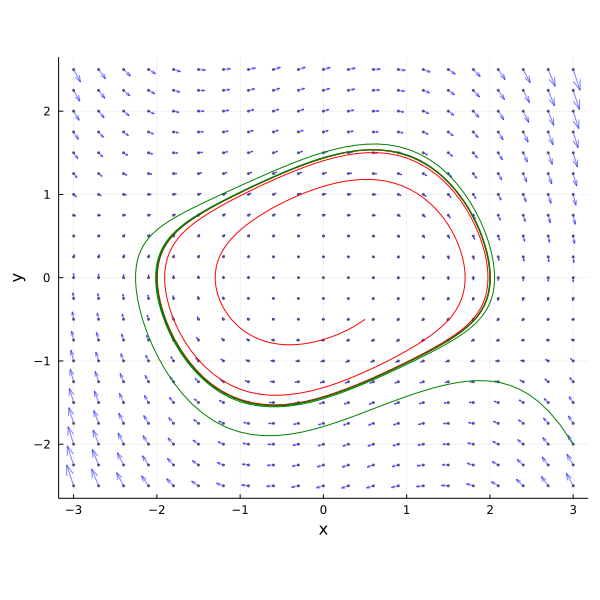

In [9]:
xlims=[-3,3]
ylims=[-2.5,2.5]
p1 = flux2d_vectorfield(vdp!,[K,γ];xlims=xlims,ylims=ylims)
sol1 = solve(ODEProblem(vdp!, [0.5;-0.5], tspan, [K,γ]))
sol2 = solve(ODEProblem(vdp!, [3.0;-2.0], tspan, [K,γ]))
plot!(p1,sol1,vars=(1,2),color=:red)
plot!(p1,sol2,vars=(1,2),color=:green,xlims=xlims,ylims=ylims)

## Puntos Fijos y Nulclinas



# Ecuacion diferencial lineal en 2D


Para el caso en el que $f$ y $g$ son funciones lineales podemos escribir de forma general:

$\dot{x} = ax+by$

$\dot{y} = cx+dy$

O de forma mas compacta usando notacion matricial

${\bf \dot{x}} = {\bf Ax}$

donde

${\bf x} = \begin{pmatrix}x\\y\end{pmatrix}\quad{\bf A} =\begin{pmatrix}a & b\\c & d\end{pmatrix}$

Cualquier termino constante que se agregue a las forma anterior se puede eliminar haciendo un cambio **lineal** de coordenadas por lo tanto decimos que esta es la forma general de un flujo 2D lineal, con un punto fijo en el origen.

Dependiendo de los autovalores de la matriz $A$ ese punto fijo puede ser atractor (nodo o espiral), repulsor (nodo o espiral), punto silla (saddle) o un centro. Vamos a ver los casos uno por uno

## Autovalores y Autovectores

Para el caso de matrices de 2x2 la ecuacion caracteristica para el calculo de los autovalores $det({\bf A} - \lambda{\bf I}) = 0$ se puede escribir como:

$\lambda^2-\tau\lambda+\Delta=0$

donde $\tau$ es la traza de la matriz ${\bf A}$, es decir $\tau=a+d$,

y $\Delta$ es el determinante de la matriz ${\bf A}$, es decir $\Delta=ad-bc$

Por lo tanto los dos autovalores de la matriz son:

$\lambda_1 = \displaystyle\frac{\tau+\sqrt{\tau^2-4\Delta}}{2} \quad \quad \lambda_2 = \displaystyle\frac{\tau-\sqrt{\tau^2-4\Delta}}{2}$ 

## Nodo atractor

en el caso en el que la matriz ${\bf A}$ tiene dos autovalores reales negativos tenemos un nodo atractor. Por ejemplo:

$\dot{x} = -x+y$

$\dot{y} = x-2y$

La matriz en este caso es

${\bf A} =\begin{pmatrix}-1 & 1\\1 & -2\end{pmatrix}$

La traza es -3 y el determinante 1. Por lo tanto
sus autovalores son ambos reales negativos $\lambda_1=(-3+\sqrt{5})/2=-0.38197$ $\lambda_2=(-3+\sqrt{5})/2=-2.61803$

Los autovalores los podemos calcular numericamente tambien usando la funcion *eig* del modulo de algebra lineal de numpy

In [ ]:
# Definimos la matriz
A = [-1 1; 1 -2]

In [ ]:
# sus autovalores
eigen(A).values

In [ ]:
#definimos la ecuacion diferencial lineal general
flinear(u,p,t) = A*u

In [ ]:
u0_arr = vec([[0.3*i-1;0.3*j-1] for i=0:6, j=0:6])
prob = ODEProblem(flinear, [0.2;0.2], (0,10))
function prob_func(prob,i,repeat)
  remake(prob,u0=u0_arr[i])
end
sol = solve(EnsembleProblem(prob,prob_func=prob_func),EnsembleThreads(),trajectories=length(u0_arr))
p1 = plot(sol,vars=(0,1))
p2 = plot(sol,vars=(1,2),arrow=true)
plot(p1,p2,layout=(1,2),size=(900,400),fmt = :png)

Notar que tiende hacia el punto fijo mas rapido en una direccion y mas lentamente en la otra, esto es debido 
a que uno de los autovalores es unas siete veces mayor que el otro, la direccion en rapida y la lenta estan dadas 
por los autovectores asociados a los autovalores

In [ ]:
av = eigen(A).vectors

In [ ]:
p1 = plot(sol,vars=(0,1),ylims=(-1,1))
p2 = plot(sol,vars=(1,2))
plot!(p2,[0,av[1,1]],[0,av[2,1]],arrow=true,linewidth=2,color=:black)
plot!(p2,[0,av[1,2]],[0,av[2,2]],arrow=true,linewidth=2,color=:black)
plot(p1,p2,layout=(1,2),size=(900,400),fmt = :png)

## Foco atractor

en el caso en el que la matriz ${\bf A}$ tiene dos autovalores complejos (conjugados) con parte real negativa tenemos un foco (espiral) atractor. Un ejemplo:

$\dot{x} = -x+-y$

$\dot{y} = x-2y$

La matriz en este caso es

${\bf A}=\begin{pmatrix}-1 & -1\\1 & -2\end{pmatrix}$

En este caso la traza sigue siendo $\tau=-3$ pero el determinante es $\Delta=3$
por lo tanto discriminante $\tau^2-4\Delta$ es negativo y los autovalores son complejos conjugados.
$\lambda_1=(-3+\sqrt{3}j)/2 = -1.5+0.866j$ , y 
$\lambda_2=(-3-\sqrt{3}j)/2 = -1.5+0.866j$

In [ ]:
A = [-1 -1; 1 -2]
eigen(A).values

In [ ]:
sol = solve(EnsembleProblem(prob,prob_func=prob_func),EnsembleThreads(),trajectories=length(u0_arr))
p1 = plot(sol,vars=(0,1))
p2 = plot(sol,vars=(1,2),arrow=true)
plot(p1,p2,layout=(1,2),size=(900,400),fmt = :png)

## Punto Silla (Saddle)

en el caso en el que la matriz ${\bf A}$ tiene un autovalor positivo y el otro negativo tenemos un punto silla. Un ejemplo:

$\dot{x} = x+y$

$\dot{y} = x-2y$

La matriz en este caso es

${\bf A}=\begin{pmatrix}1 & 1\\1 & -2\end{pmatrix}$

La traza es ahora $\tau=-1$ y el determinante es negativo $\Delta=-3$
Los autovalores: 1.3027 y -2.3027

SIEMPRE que el Determinante es negativo los autovalores son uno positivo y otro negativo porque estamos sumando y restando a $\tau$ un numero que es mayor a $\tau$ (la raiz del discriminante), por lo tanto tenemos un punto silla

In [ ]:
A = [1 1; 1 -2]
eigen(A).values

In [ ]:
prob = ODEProblem(flinear, [0.2;0.2], (0,3))
sol = solve(EnsembleProblem(prob,prob_func=prob_func),EnsembleThreads(),trajectories=length(u0_arr))
p1 = plot(sol,vars=(0,1),ylims=(-1,1))
p2 = plot(sol,vars=(1,2),arrow=true,xlims=(-1,1),ylims=(-1,1))
av = eigen(A).vectors
print(av)
plot!(p2,[av[1,1],0],[av[2,1],0],arrow=true,linewidth=2,color=:black)
plot!(p2,[0,av[1,2]],[0,av[2,2]],arrow=true,linewidth=2,color=:black)
plot(p1,p2,layout=(1,2),size=(900,400),fmt = :png)

 Los autovectores (columna) 
 
$\begin{pmatrix}0.9571 \\0.2898\end{pmatrix} \quad \begin{pmatrix}-0.2898\\0.9571\end{pmatrix}$

corresponden a los autovalores negativo (atraccion) y positivo (repulsor) y como vectores en el plano $(x,y)$ e indican las direcciones a lo largo de las cuales el flujo 2D es atraido y repelido respectivamente

## Nodo y Foco Repulsor
Cambiando el signo de los flujos de arriba  se pueden obtener un nodo y foco repulsor. Al cambiar el signo de $a,b,c,d$ cambia de signo la Traza pero no el Determinante. 

El signo de la traza es el que me da la estabilidad del nodo/foco. Traza negativa es estable y traza positiva es inestable

## Centro

Para el caso particular en el que la parte real del autovalor se hace cero tenemos un centro, esto sucede para un valor especifico de parametros y no es generico como los puntos anteriores (o estructuralmente estable). Cualquier perturbacion de un centro me lleva a un foco atractor a uno repulsor. De hecho podemos ver al centro como el cambio de estabilidad de un foco repulsor a uno atractor. 

Un ejemplo clasico de un repulsor es el del oscilador armonico sin friccion

$\dot{x} = y$

$\dot{y} = -x$

La matriz en este caso es

${\bf A}=\begin{pmatrix}0 & 1\\-1 & 0\end{pmatrix}$

y tiene como autovalores: j y -j

In [ ]:
A = [0 1; -1 0]
eigen(A).values

In [ ]:
sol = solve(EnsembleProblem(prob,prob_func=prob_func),EnsembleThreads(),trajectories=length(u0_arr))
p1 = plot(sol,vars=(0,1))
p2 = plot(sol,vars=(1,2),arrow=true)
plot(p1,p2,layout=(1,2),size=(900,400),fmt = :png)

# Clasificacion de los sistemas lineales 

A partir de la Traza y el Determinante podemos clasificar los puntos fijos segun su tipo y estabilidad.

En el siguiente grafico interactivo para simplificar podemos asumir que en la matriz 

$\begin{pmatrix}a & b\\c & d\end{pmatrix}$

$b=1$, y podemos ajustar la traza y el determinante de forma independiente y a partir de esos dos valores y de un valor libre de $d$ podemos determinar los valores de $a$ y $b$. La matriz entonces va a ser

$\begin{pmatrix}Tr - d & 1\\(Tr-d)d-\Delta & d\end{pmatrix}$

Puede resultar un poco rebuscado pero es mas intuitivo ajustar la traza y el determinante, sobre todo mirando el grafico de la derecha (a la izquierda esta el flujo), que controlando los elementos de la matriz ($a,b,c,d$) de forma independiente. De todas formas en el grafico donde se muestra la ubicacion del punto en el grafico de traza y determinante se muestran tambien los valores de la matriz.

Notar que lo que influye en la estabilidad son solo la Traza y el Determinante, el elemento $d$ lo que hace es rotar el flujo o cambiar la velocidad de las trayectorias.

In [ ]:
# ESTO ES INTERACTIVO EN EL NAVEGADOR
#traza = -0.5; determ = 0.5; d=1.0
@manipulate throttle=0.5 for traza=-1.8:0.02:1.8, determ=-1:0.01:1, d=-1:0.01:1
    b=1.0;
    a=traza-d;
    c=(a*d-determ)/b
    A = round.([a b; c d],digits=2)
    classification_linear(A)
end    

# Nulclinas 

Para el Flujo 2D general:

$\dot{x} = f(x,y)$

$\dot{y} = g(x,y)$

los puntos fijos seran aquellos que satisfacen simultaneamente

$f(x,y) = 0$

$g(x,y) = 0$

Cada una de estas ecuaciones se puede ver como la forma implicita de una curva en el plano $(x,y)$ y se conoce como *nulclina*. Podemos representar esas dos curvas en el plano (la nulclina de $\dot{x}=0$ y la nulclina de $\dot{y}=0$). Los puntos fijos estaran entonces en los puntos donde se corten estas dos curvas. Claramente para el caso lineal las nulclinas son dos rectas que de forma generica se cortan en solo un punto.

Vamos a incorporar una representacion del espacio de fases bidimensional que nos va a ayudar a inferir el flujo, al menos en los casos mas simples, sin necesidad de integrar el sistema.

Vamos a representar las curvas nulclinas $\dot{x}=0$ en rojo y $\dot{y}=0$ en azul. Pero tambien vamos a diferenciar las regiones que dividen estas nulclinas con colores con transparencia. 

En combinacion con los colores transparentes de la nulclina anterior tenemos cuatro tipo de regiones:

- color verde + azul = cyan donde el flujo va hacia la derecha ($\dot{x}>0$) y abajo ($\dot{y}<0$)
- color verde + amarillo = verde donde el flujo va hacia la derecha ($\dot{x}>0$) y arriba ($\dot{y}>0$)
- color rojo + amarillo = naranja donde el flujo va hacia la izquierda ($\dot{x}<0$) y arriba ($\dot{y}>0$)
- color rojo + azul = magenta donde el flujo va hacia la izquierda ($\dot{x}<0$) y abajo ($\dot{y}<0$)

Como dato adicional estos colores se forman cuatro regiones que se juntan en el punto fijo y el ordenamiento de estas regiones nos permite decidir si el punto fijo es un punto silla o no, si el ordenamiento es cyan-verde-naranja-magenta en sentido antihorario es un nodo/foco, si en cambio ese ordenamiento esta en sentido horario es un punto silla. Esto es tambien porque si tomamos a la matriz A como una transformacion lineal en el plano, cuando su determinante es negativo esa tranformacion "invierte" el plano como si estuviesemos viendo el plano como una hoja de papel desde el otro lado. 

In [10]:
function flinearin!(du,u,p,t)
    (a,b,c,d)=p
    du[1]=a*u[1]+b*u[2]
    du[2]=c*u[1]+d*u[2]
    du
end

flinearin! (generic function with 1 method)

In [11]:
# ESTO ES INTERACTIVO EN EL NAVEGADOR
xlims=[-1.0,1.0];ylims=[-1.0,1.0]; Ngrid=7
xrange = xlims[2]-xlims[1]
yrange = ylims[2]-ylims[1]
u0_arr = vec([[xlims[1]+i*xrange/Ngrid,ylims[1]+j*yrange/Ngrid] for i=0:Ngrid, j=0:Ngrid])
@manipulate throttle=0.5 for traza=-2:0.02:2, determ=-1:0.01:1, d=-1:0.01:1
    b=1.0;
    a=traza-d;
    c=(a*d-determ)/b
    A = [a b; c d]
    flux2d_nullclines(flinearin!,u0_arr,2.0,[a,b,c,d];size=(500,500))
end    

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["traza"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 201, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
101, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "C:\\Users\\Camilo\\.julia\\packages\\Knockout\\3gjS1\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\Camilo\\.julia\\packages\\Knockout\\3gjS1\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\Camilo\\.julia\\packages\\InteractBase\\h8Fwe\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\Camilo\\.julia\\packages\\InteractBase\\h8Fwe\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\Camilo\\.julia\\packages\\Interact\\pVyN2\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000008341c4c0, Task (runnable) @0x000000008341c4c0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"-2.0\",\"-1.98\",\"-1.96\",\"-1.94\",\"-1.92\",\"-1.9\",\"-1.88\",\"-1.86\",\"-1.84\",\"-1.82\",\"-1.8\",\"-1.78\",\"-1.76\",\"-1.74\",\"-1.72\",\"-1.7\",\"-1.68\",\"-1.66\",\"-1.64\",\"-1.62\",\"-1.6\",\